In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine = pudl.db_connect_pudl()
frc_contracts = pd.read_sql('''SELECT report_date, contract_expiration_date, fuel_group
                               FROM fuel_receipts_costs_eia923;''', pudl_engine)
frc_contracts['report_date'] = pd.to_datetime(frc_contracts['report_date'])
frc_contracts['contract_expiration_date'] = pd.to_datetime(frc_contracts['contract_expiration_date'])
frc_contracts['remaining_contract_time'] = frc_contracts.contract_expiration_date - frc_contracts.report_date
frc_contracts['remaining_contract_time'] = frc_contracts['remaining_contract_time'].apply(lambda x: np.nan if x is None else x)
frc_contracts.dropna(subset=['remaining_contract_time'], inplace=True)
frc_contracts = frc_contracts[frc_contracts['remaining_contract_time']>pd.to_timedelta('0 days')]
frc_contracts['tot_months'] = frc_contracts.remaining_contract_time.dt.total_seconds()/(30*60*60*24)

coal_by_year = {}
gas_by_year = {}
for yr in range(2009,2016):
    start = pd.to_datetime('{}-01-01'.format(yr))
    end = pd.to_datetime('{}-12-31'.format(yr))
    mask = (frc_contracts['report_date'] >= start) & (frc_contracts['report_date'] <= end)
    contracts_by_year = frc_contracts.loc[mask]
    coal_by_year[yr] = contracts_by_year[contracts_by_year['fuel_group']=='Coal']
    gas_by_year[yr] = contracts_by_year[contracts_by_year['fuel_group']=='Natural Gas']

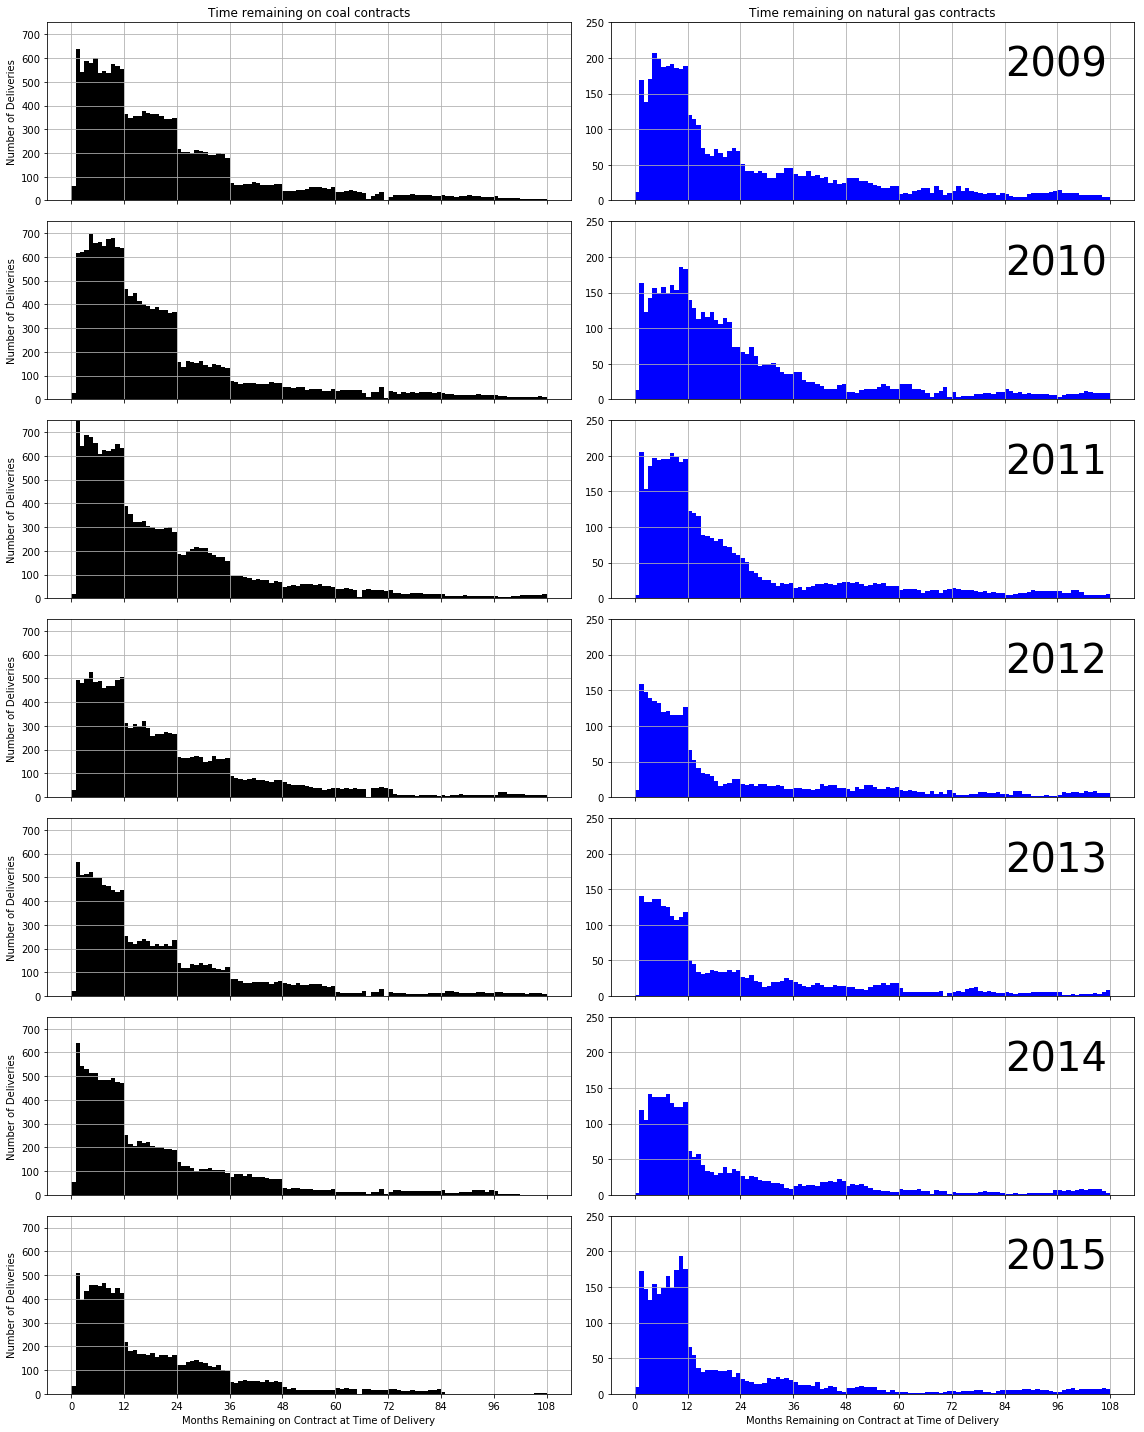

In [3]:
fig, axarr = plt.subplots(7,2, sharex=True)
fig.set_figwidth(16)
fig.set_figheight(20)

years = range(2009,2016)
for (yr,coal_ax) in zip(years, axarr[:,0]):
    if yr == min(years):
        coal_ax.set_title("Time remaining on coal contracts")
    coal_ax.grid()
    coal_ax.hist(coal_by_year[yr]['tot_months'], bins=108, range=(0,108), label='Coal', color='black')
    coal_ax.set_xticks(np.arange(0,120,12))
    coal_ax.set_ylim(0,750)
    coal_ax.set_ylabel("Number of Deliveries")
coal_ax.set_xlabel("Months Remaining on Contract at Time of Delivery")

for (yr,gas_ax) in zip(years,axarr[:,1]):
    if yr == min(years):
        gas_ax.set_title("Time remaining on natural gas contracts")
    gas_ax.grid()
    gas_ax.hist(gas_by_year[yr]['tot_months'], bins=108, range=(0,108), label='Natural Gas', color='blue')
    gas_ax.set_xticks(np.arange(0,120,12))
    gas_ax.set_ylim(0,250)
    gas_ax.text(84, 175, str(yr), fontsize=40)
gas_ax.set_xlabel("Months Remaining on Contract at Time of Delivery")

plt.tight_layout()
plt.show()